In [2]:
# Python imports, put at the top for simplicity
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from docs.notebooks.utils import render_service, render_target, render_composition_mdp, print_policy_data, print_value_function, print_q_value_function
from stochastic_service_composition.composition import composition_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions

In [3]:
DEFAULT_REWARD = -1.0
DEFAULT_BROKEN_REWARD = -10.0
DEFAULT_BROKEN_PROB = 0.05


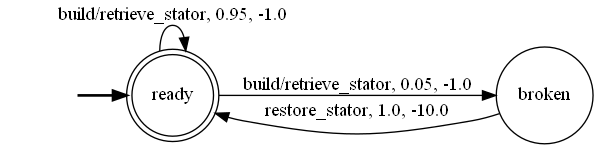

In [4]:
def stator_builder_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob
    transitions = {
        "ready": {
          "build/retrieve_stator": ({"ready": success_prob, "broken": broken_prob}, action_reward),
        },
        "broken": {
            "restore_stator": ({"ready": 1.0}, broken_reward),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore
service_stator_builder=stator_builder_service()
render_service(service_stator_builder)

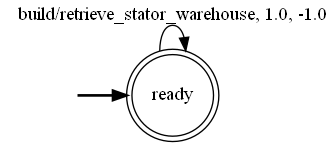

In [5]:
def stator_warehouse_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            "build/retrieve_stator_warehouse": ({"ready": 1.0}, action_reward),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_stator_warehouse=stator_warehouse_service()
render_service(service_stator_warehouse)

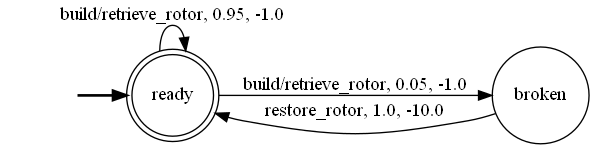

In [6]:
def rotor_builder_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the rotor builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob
    transitions = {
        "ready": {
          "build/retrieve_rotor": ({"ready": success_prob, "broken": broken_prob}, action_reward),
        },
        "broken": {
            "restore_rotor": ({"ready": 1.0}, broken_reward),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore
service_rotor_builder=rotor_builder_service()
render_service(service_rotor_builder)

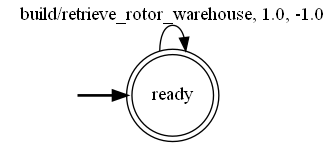

In [7]:
def rotor_warehouse_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the rotor warehouse device."""
    transitions = {
        "ready": {
            "build/retrieve_rotor_warehouse": ({"ready": 1.0}, action_reward),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_rotor_warehouse=rotor_warehouse_service()
render_service(service_rotor_warehouse)

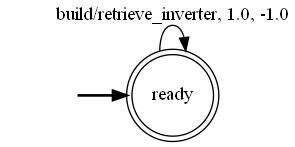

In [8]:
def inverter_warehouse_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the inverter warehouse device."""
    transitions = {
        "ready": {
            "build/retrieve_inverter": ({"ready": 1.0}, action_reward),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_inverter_warehouse=inverter_warehouse_service()
render_service(service_inverter_warehouse)

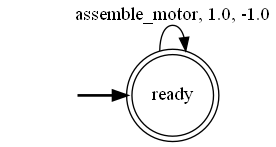

In [9]:
def assembler_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the assembler device."""
    transitions = {
        "ready": {
            "assemble_motor": ({"ready": 1.0}, action_reward),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_assembler=assembler_service()
render_service(service_assembler)

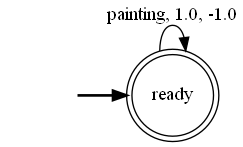

In [10]:
def painter_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the painter device."""
    transitions = {
        "ready": {
            "painting": ({"ready": 1.0}, action_reward),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_painter=painter_service()
render_service(service_painter)

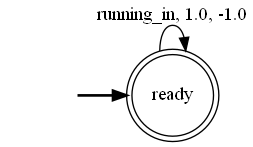

In [11]:
def smart_tester_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the smart tester device."""
    transitions = {
        "ready": {
            "running_in": ({"ready": 1.0}, action_reward),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_smart_tester=smart_tester_service()
render_service(service_smart_tester)

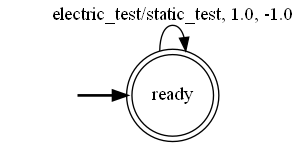

In [12]:
def mechanical_engineer_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the mechanical engineer device."""
    transitions = {
        "ready": {
            "electric_test/static_test": ({"ready": 1.0}, action_reward),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_mechanical_engineer=mechanical_engineer_service()
render_service(service_mechanical_engineer)

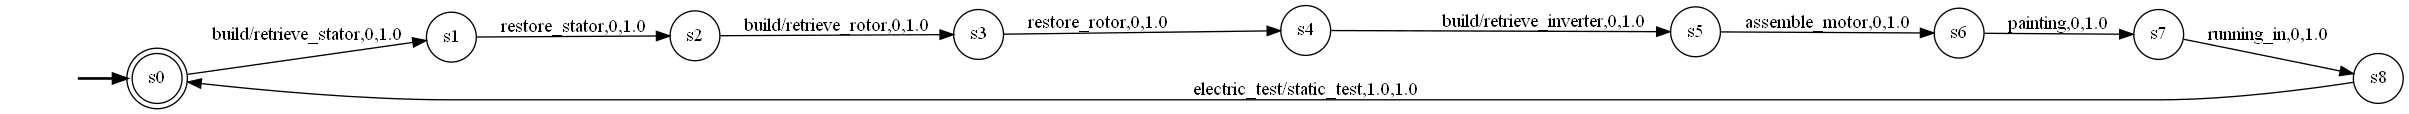

In [13]:
def target_service():
    """Build the target service."""
    transition_function = {
        "s0": {
            "build/retrieve_stator": ("s1", 1.0, 0),
        },
        "s1": {"restore_stator": ("s2", 1.0, 0),
        },
        "s2": {"build/retrieve_rotor": ("s3", 1.0, 0),},
        "s3": {"restore_rotor": ("s4", 1.0, 0),},
        "s4": {"build/retrieve_inverter": ("s5", 1.0, 0), },
        "s5": {"assemble_motor": ("s6", 1.0, 0), },
        "s6": {"painting": ("s7", 1.0, 0), },
        "s7": {"running_in": ("s8", 1.0, 0), },
        "s8": {"electric_test/static_test": ("s0", 1.0, 1.0), },

    }

    initial_state = "s0"
    final_states = {"s0"}

    return build_target_from_transitions(
        transition_function, initial_state, final_states
    )

target = target_service()
render_target(target)

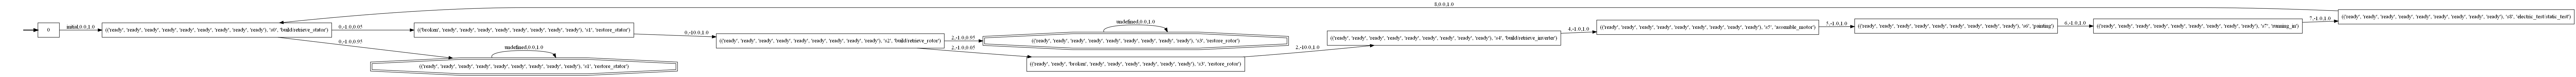

In [14]:
all_services = [
    service_stator_builder,
    service_stator_warehouse,
    service_rotor_builder,
    service_rotor_warehouse,
    service_inverter_warehouse,
    service_assembler,
    service_painter,
    service_smart_tester,
    service_mechanical_engineer,
]

mdp = composition_mdp(target, *all_services, gamma=0.9)
render_composition_mdp(mdp)

In [15]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
_ = q_value_function.pop(0, None)

In [16]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'restore_stator'),	Action=0
State=(('ready', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's3', 'restore_rotor'),	Action=2
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's0', 'build/retrieve_stator'),	Action=0
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'restore_stator'),	Action=undefined
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's2', 'build/retrieve_rotor'),	Action=2
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's3', 'restore_rotor'),	Action=undefined
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's4', 'build/retrieve_inverter'),	Action=4
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready

In [17]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'restore_stator'),	value=-11.4629773912658
State=(('ready', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's3', 'restore_rotor'),	value=-13.900676327550627
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's0', 'build/retrieve_stator'),	value=-1.5158339826069611
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'restore_stator'),	value=0.0
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's2', 'build/retrieve_rotor'),	value=-1.6255304347397783
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's3', 'restore_rotor'),	value=0.0
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's4', 'build/retrieve_inverter'),	value=-4.334084808389585
State=(('r

In [18]:
print_q_value_function(q_value_function)

Q-value function:
State=(('broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'restore_stator'):
	Action=0,	Value=-11.4629773912658

State=(('ready', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's3', 'restore_rotor'):
	Action=2,	Value=-13.900676327550627

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's0', 'build/retrieve_stator'):
	Action=0,	Value=-1.515833982606961

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'restore_stator'):
	Action=undefined,	Value=0.0

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's2', 'build/retrieve_rotor'):
	Action=2,	Value=-1.6255304347397783

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's3', 'restore_rotor'):
	Action=undefined,	Value=0.0

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready',